# Single atom training
This notebook goes through the workflow of setting the hyperparameters, collecting atom manipulation data, and training the deep reinforcement learning agent.

### Importing modules

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from collections import deque, namedtuple
from matplotlib import pyplot as plt, patches
import torch
from AMRL import RealExpEnv, Episode_Memory, Createc_Controller, sac_agent, ReplayMemory, HerReplayMemory
from AMRL import plot_graph, show_reset, show_done, show_step
matplotlib.rcParams['image.cmap'] = 'gray'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
from matplotlib import pyplot as plt, patches

cpu


### Setting the anchor image
This cell retrieves the current STM scan image and use it as the template for positioning the anchor in STM images

succeed to connect


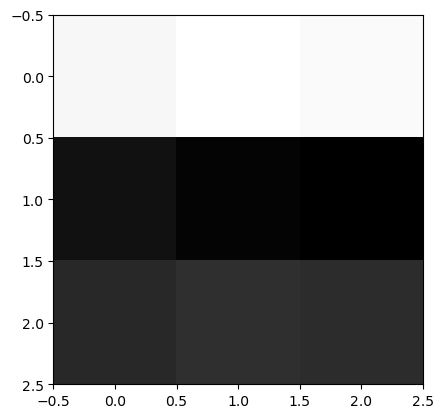

In [2]:
createc_controller = Createc_Controller(None, None, None, None)
img_forward = np.array(createc_controller.stm.scandata(1,4))
#TODO
#Set the pixel of the top-left corner, widht, and height of the anchor
#If the anchor is not used, just set w and h to a small number like below
top_left, w, h = (0,0), 3, 3
#template = img_forward[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]
#plt.imshow(template)

template = img_forward[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]
plt.imshow(template)

### Set the parameters and create a RealExpEnv object

In [3]:
#TODO
step_nm = 0.4 #Set the radius of the manipulation start position relative the the atom start position
goal_nm  = 2 #Set the radius of the manipulation end position relative the the atom start position
max_mvolt = 15 #Set the maximum bias voltage in mV 
max_pcurrent_to_mvolt_ratio = 6E3 #Set the maximum conductance in pA/mV
max_len = 5 #Set maximum episode length
template_max_y = 3 #Set the maximum or minimum row number to search for anchor
#Set the path to load CNN weight for the atom movement classifier
CNN_weight_path = 'C:/Users/wun2/github/Atom_manipulation_with_RL/training_data_and_model_parameters/model parameters/_atom_move_detector_conv_2460.pth'
current_jump  = 4 #Set the current jump gradient/ std(current) threshold required to take STM scan

#Set STM scan parameters
pixel = 128
im_size_nm = 5 #Image size in nm 
scan_mV = 500 #bias voltage
x_nm, y_nm = createc_controller.get_offset_nm()
offset_nm = np.array([x_nm, y_nm]) #Set offset to current offset value

#Set manipulation parameters to pull atoms from image edge to center
pull_back_mV = 5 #bias in mV
pull_back_pA = 60000 #current in pA

#Set manipulation limit [left, right, up, down] in nm
manip_limit_nm = np.array([x_nm - 0.5*im_size_nm+0.25, x_nm + 0.5*im_size_nm-0.25, y_nm+0.25, y_nm+im_size_nm-0.25])

env = RealExpEnv(step_nm, max_mvolt, max_pcurrent_to_mvolt_ratio, goal_nm, 
                 template, current_jump, im_size_nm, offset_nm, manip_limit_nm, pixel, 
                 template_max_y, scan_mV, max_len, 
                 CNN_weight_path, 
                 bottom=False, random_scan_rate = 0.8, pull_back_mV = pull_back_mV,
                 pull_back_pA = pull_back_pA)

succeed to connect
Load cnn weight


In [ ]:
createc_controller.stm.setparam('Delta X [DAC]', 118)
createc_controller.stm.setparam('BiasVolt.[mV]', 50)
createc_controller.stm.setparam('ZPiezoconst', 8.43)
createc_controller.stm.setparam('SetPoint', 5.00E-12)
createc_controller.stm.setparam('FBLogIset', 50)
env.createc_controller.stm.setparam('TipForm_Volt', -3) # Set the bias voltage for the atom manipulation(unit V)
env.createc_controller.stm.setparam('TipForm_Z', 0.0) # Set the z position for the atom manipulation(unit angstrom)
env.createc_controller.stm.setparam('Tip_Delay', 0.4915) # Set the delay time for the atom manipulation(unit s)
env.createc_controller.stm.setparam('Tip_Latddx', 833) # Set the lateral ddx for the atom manipulation(unit angstrom/ms^2)
env.createc_controller.stm.setparam('Tip_LatDelay', 20) # Set the lateral delay for the atom manipulation(unit ms)
env.createc_controller.stm.setparam('Tip_Gain', 6) # Set the gain for the atom manipulation(unit 1)
env.createc_controller.stm.setparam('TipForm_Zoffset', 0.0) # Set the z offset for the atom manipulation(unit angstrom)



### Create a sac_agent object

In [4]:
#TODO
batch_size= 64 #Set minibatch size
LEARNING_RATE = 0.0003 #Set learning rate

#Set the action space range
ACTION_SPACE = namedtuple('ACTION_SPACE', ['high', 'low'])
action_space = ACTION_SPACE(high = torch.tensor([1,1,1,1,1,1]), low = torch.tensor([-1,-1,-1,-1,1/3,1/2]))

#Initialize the soft actor-critic agent
alpha = 1.0
agent = sac_agent(num_inputs = 4, num_actions = 6, action_space = action_space, device=device, hidden_size=256, lr=LEARNING_RATE,
                 gamma=0.9, tau=0.005, alpha=alpha)

### Create a HerReplayMemory object
Here we use the hindsight experience replay with the 'future' strategy to sample goals

In [5]:
#TODO
replay_size=1000000 #Set memory size

memory = HerReplayMemory(replay_size, env, strategy = 'future')

### Create a Episode_Memory object
The episode memory class is used to store all the relavant information in each training episode, including the STM images, state, action, reward, etc.

In [7]:
episode_memory = Episode_Memory()
#TODO
#Set the folder name to store training data and neural network weight
folder_name =  'C:/Users/wun2/github/Atom_manipulation_with_RL/test_nian'

### Set the hyperparameters for Emphasize Recent Experience replay

In [8]:
c_k_min = 500
eta = 0.994
max_ep_len = max_len

### Create empty lists for logging performances

In [9]:
episode_rewards, alphas, precisions, episode_lengths = [], [], [], []
avg_episode_rewards, avg_alphas, avg_precisions, avg_episode_lengths = [], [], [], []

In [10]:
max_steps = 5
num_episodes = 50
episode_start = 0

In [ ]:
for i_episode in range(episode_start,episode_start+num_episodes):
    print('Episode:', i_episode)
    episode_reward, episode_steps = 0, 0
    done = False
    state, info = env.reset(update_conv_net=False)
    show_reset(env.img_info, env.atom_start_absolute_nm, env.destination_absolute_nm,
            env.template_nm, env.template_wh)
    episode_memory.update_memory_reset(env.img_info, i_episode, info)
    
    for step in range(max_steps):
        action = agent.select_action(state)
        old_atom_nm = env.atom_absolute_nm
        next_state, reward, done, info = env.step(action)
        episode_steps+=1
        episode_reward+=reward
        mask = float(not done)
        memory.push(state,action,reward,next_state,mask)
        episode_memory.update_memory_step(state, action, next_state, reward, done, info)
        show_step(env.img_info, info['start_nm']+old_atom_nm, info['end_nm']+old_atom_nm,
                    env.atom_absolute_nm, env.atom_start_absolute_nm, 
                    env.destination_absolute_nm, action[4]*env.max_mvolt, 
                    action[5]*env.max_pcurrent_to_mvolt_ratio*action[4]*env.max_mvolt, 
                    env.template_nm, env.template_wh)
        print('step:', step,'reward', reward, 'precision:', env.dist_destination)
        if done:
            episode_memory.update_memory_done(env.img_info, env.atom_absolute_nm, env.atom_relative_nm)
            episode_memory.save_memory(folder_name)
            print('Episode reward:', episode_reward)
            break
        else:                
            state=next_state
        
    if (len(memory)>batch_size):
        episode_K = int(episode_steps)
        for k in range(episode_K):
            c_k = max(int(memory.__len__()*eta**((k)*(1000/episode_K))), 500)
            agent.update_parameters(memory, batch_size, c_k)
    
    episode_rewards.append(episode_reward)
    alphas.append(agent.alpha.item())
    precisions.append(env.dist_destination)
    episode_lengths.append(episode_steps)
    avg_episode_rewards.append(np.mean(episode_rewards[-min(100,len(episode_rewards)):]))
    avg_alphas.append(np.mean(alphas[-min(100, len(alphas)):]))
    avg_precisions.append(np.mean(precisions[-min(100, len(precisions)):]))
    avg_episode_lengths.append(np.mean(episode_lengths[-min(100, len(episode_lengths)):]))
    
    if (i_episode+1)%2==0:
        plot_graph(episode_rewards, precisions, alphas, episode_lengths,
                avg_episode_rewards, avg_alphas, avg_precisions, avg_episode_lengths)
        
    if (i_episode)%20 == 0:
        torch.save(agent.critic.state_dict(), '{}/_critic_{}.pth'.format(folder_name,i_episode))
        torch.save(agent.policy.state_dict(), '{}/_policy_{}.pth'.format(folder_name,i_episode))
        torch.save(agent.alpha, '{}/_alpha_{}.pth'.format(folder_name,i_episode))
        torch.save(env.atom_move_detector.conv.state_dict(), '{}/_atom_move_detector_conv_{}.pth'.format(folder_name,i_episo

# Define the training function

In [ ]:
def sac_train(max_steps = max_len, num_episodes = 50, episode_start = 0):
    """
    Collect training data and train the RL agent

    Parameters
    ----------
    max_steps: int
            maximum steps in an episode
            
    num_episodes: int
            Train for this many episodes
    
    episode_start: int
            Index to use for the starting episode

    Returns
    -------
    None : None
    """
    for i_episode in range(episode_start,episode_start+num_episodes):
        print('Episode:', i_episode)
        episode_reward, episode_steps = 0, 0
        done = False
        state, info = env.reset(update_conv_net=False)
        show_reset(env.img_info, env.atom_start_absolute_nm, env.destination_absolute_nm,
                   env.template_nm, env.template_wh)
        episode_memory.update_memory_reset(env.img_info, i_episode, info)
        
        for step in range(max_steps):
            action = agent.select_action(state)
            old_atom_nm = env.atom_absolute_nm
            next_state, reward, done, info = env.step(action)
            episode_steps+=1
            episode_reward+=reward
            mask = float(not done)
            memory.push(state,action,reward,next_state,mask)
            episode_memory.update_memory_step(state, action, next_state, reward, done, info)
            show_step(env.img_info, info['start_nm']+old_atom_nm, info['end_nm']+old_atom_nm,
                        env.atom_absolute_nm, env.atom_start_absolute_nm, 
                        env.destination_absolute_nm, action[4]*env.max_mvolt, 
                        action[5]*env.max_pcurrent_to_mvolt_ratio*action[4]*env.max_mvolt, 
                        env.template_nm, env.template_wh)
            print('step:', step,'reward', reward, 'precision:', env.dist_destination)
            if done:
                episode_memory.update_memory_done(env.img_info, env.atom_absolute_nm, env.atom_relative_nm)
                episode_memory.save_memory(folder_name)
                print('Episode reward:', episode_reward)
                break
            else:                
                state=next_state
             
        if (len(memory)>batch_size):
            episode_K = int(episode_steps)
            for k in range(episode_K):
                c_k = max(int(memory.__len__()*eta**((k)*(1000/episode_K))), 500)
                agent.update_parameters(memory, batch_size, c_k)
        
        episode_rewards.append(episode_reward)
        alphas.append(agent.alpha.item())
        precisions.append(env.dist_destination)
        episode_lengths.append(episode_steps)
        avg_episode_rewards.append(np.mean(episode_rewards[-min(100,len(episode_rewards)):]))
        avg_alphas.append(np.mean(alphas[-min(100, len(alphas)):]))
        avg_precisions.append(np.mean(precisions[-min(100, len(precisions)):]))
        avg_episode_lengths.append(np.mean(episode_lengths[-min(100, len(episode_lengths)):]))
        
        if (i_episode+1)%2==0:
            plot_graph(episode_rewards, precisions, alphas, episode_lengths,
                      avg_episode_rewards, avg_alphas, avg_precisions, avg_episode_lengths)
            
        if (i_episode)%20 == 0:
            torch.save(agent.critic.state_dict(), '{}/_critic_{}.pth'.format(folder_name,i_episode))
            torch.save(agent.policy.state_dict(), '{}/_policy_{}.pth'.format(folder_name,i_episode))
            torch.save(agent.alpha, '{}/_alpha_{}.pth'.format(folder_name,i_episode))
            torch.save(env.atom_move_detector.conv.state_dict(), '{}/_atom_move_detector_conv_{}.pth'.format(folder_name,i_episo

# Train the RL agent

In [ ]:
sac_train(episode_start = 2896,num_episodes = 1000)

# find a section to condition tip

In [ ]:

start_crash_hole=0
approach_z=2

def tip_cond_area(center_x=0, center_y=0, approach_area_length=800, cond_area_length=200, margin=20):
    cond_area_center_x, cond_area_center_y=center_x-approach_area_length+cond_area_length+margin, center_y-approach_area_length+cond_area_center_y+margin
    return cond_area_center_x, cond_area_center_y, cond_area_length

env.default_max_radius_cellsize(cellsize=20, max_radius=200)
points=env.computeLocationIDs()
cond_area_center_x, cond_area_center_y, cond_area_length=tip_cond_area()

env.createc_controller.ramp_bias_mV(-1.2)
env.createc_controller.tip_form(approach_z, cond_area_center_x+points[start_crash_hole][0]*cellsize,cond_area_center_y+points[start_crash_hole][1]*cellsize)
print(env.createc_controller.im_size_nm)
start_crash_hole=start_crash_hole

# Problem situations:

In [ ]:
start_x = 0
start_y = 0
tip_x = 0
tip_y = 0
check_similarity=None
check_similarity.append([tip_x, tip_y])
radius = 35
upper_limit_move=400
env.max_radius=150

image_forward = info['img_info']['img_forward']
image_backward =info['img_info']['img_backward']


# dectect atoms
isAtom = False



# debris
debris_thres = 6
DebresCounter = 0
noDebris = False



# Crash dectected
crash_thres = 1e-25 
approach_z = 4
noCrash = False


while not isAtom or not noDebris or not noCrash:
    
    # detect atoms
    atom_forward = blob_detection(info[img_forward])[0]

    if len(atom_forward)>0:
        isAtom = True

    # detect debris
    noDebris =  ((np.max(image_forward) - np.min(image_forward)) < debris_thres) 
    
    # dectect crash
    noCrash = (np.max(img_forward)-np.min(img_forward) )< crash_thres and (np.mean(img_forward)>0)
    
    if isAtom and noDebris and noCrash:
        continue
        
        
        
    else:
        tip_x, tip_y=env.GetNextGoodClosest(tip_x, tip_y, initial_x=start_x, initial_y=start_y, forbiden_radius=radius, upper_limit_move=upper_limit_move,approach_limit=[-180, 180, -180, 180],check_similarity=check_similarity) 
        if tip_x==None:
            tip_x, tip_y=check_similarity[-1][0], check_similarity[-1][1]
            image=env.set_newtip_pos(tip_x, tip_y)
            image_forward, image_backward =image[0], image[1]
            radius=radius*2
            env.max_radius=env.max_radius*2
            upper_limit_move=upper_limit_move+20000
        else:
            radius=35
            upper_limit_move=400
            env.max_radius=150
                
    
            
            
    check_similarity.append([tip_x, tip_y])        
    if radius>280:
        print('there is no section satisfying the demand within radius of 280 nm')
        break

    

        
        
    
    



# Condition probe

In [ ]:
env.createc_controller.stm.setparam('TipForm_Volt', -3) # Set the bias voltage for the atom manipulation(unit V)

env.createc_controller.stm.setparam('TipForm_Z', 0.0) # Set the z position for the atom manipulation(unit angstrom)

env.createc_controller.stm.setparam('Tip_Delay', 0.4915) # Set the delay time for the atom manipulation(unit s)
env.createc_controller.stm.setparam('Tip_Latddx', 833) # Set the lateral ddx for the atom manipulation(unit angstrom/ms^2)
env.createc_controller.stm.setparam('Tip_LatDelay', 20) # Set the lateral delay for the atom manipulation(unit ms)
env.createc_controller.stm.setparam('Tip_Gain', 6) # Set the gain for the atom manipulation(unit 1)
env.createc_controller.stm.setparam('TipForm_Zoffset', 0.0) # Set the z offset for the atom manipulation(unit angstrom)



In [ ]:
tip_condition_actions={'stall': [0, 0],
                      'soft pulse pos':[0, 2.5],
                      'medium pulse pos': [0, 4.0],
                      'soft pulse neg': [0 , -2.5], 
                      'medium pulse neg': [0, -4],
                      'strong pulse neg': [0, -8],
                      'very soft dip': [0, -8],
                      'soft dip 1': [-0.80, 0.02],
                      'soft dip 2': [-1.2, 0.02],
                      'soft dip 3': [-1.8, 0.02],
                      'medium soft': [-2.5, 0.02],
                      'strong dip': [-5.0, 0.02]
                      }


In [ ]:
def tip_form(self, dip_z_nm: float, voltage: float, x_nm: float, y_nm: float) -> None:
    """Perform tip forming
    Parameters
    ----------
    dip_z_nm : float
        Z approach value in A
    voltage : float
        Voltage value in V
    x_nm, y_nm : float
        STM coordinates (nm)
    """
    offset_nm = self.get_offset_nm()
    len_nm = self.get_len_nm()
    self.stm.setparam('BiasVolt.[mV]',Voltage)
    self.ramp_bias_mV(mvoltage)
    preamp_grain = 10**float(self.stm.getparam("Latmangain"))
    self.stm.setparam("LatmanVolt",  mvoltage) #(mV)
#     self.stm.setparam("Latmanlgi", pcurrent*1e-9*preamp_grain) #(pA)
    
    self.set_Z_approach(A)
    args = x_nm, y_nm, None, None, offset_nm, len_nm
    x_pixel, y_pixel, _, _ = self.nm_to_pixel(*args)
    self.stm.btn_tipform(x_pixel, y_pixel)
    self.stm.waitms(50)

### Define the training function

In [11]:
env.dist_destination=0.3934795995776328